# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
Unzip the face_dataset.tar.gz and locate them into your data directory. Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [1]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

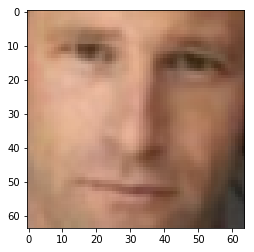

[ 1.56834639  1.73720325 -0.92972867]


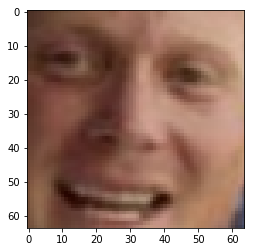

[ 0.16985062  0.42270934 -1.28218444]


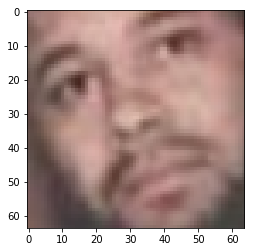

[ 0.99774898 -0.15737693 -0.75644725]


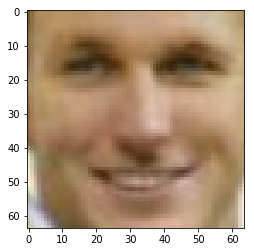

[ 1.12271853  1.91614437 -2.51421429]


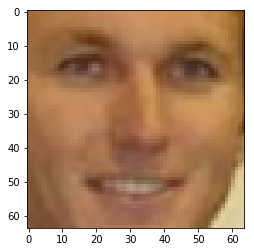

[ 1.07821424  1.67621104 -2.27805594]


In [2]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])

## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [3]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 300
display_step = 50
sample_size = 100
y_dim = 3
channel = 3


It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [4]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    #### TODO ####
    with tf.variable_scope('gen'):
        z = tf.concat([z, y], 1)
        initializer = tf.random_normal_initializer(stddev=0.01) #tf.contrib.layers.xavier_initializer()
        
        w1 = tf.get_variable('w1', [z.shape[1], 1024], tf.float32, initializer = initializer)
        b1 = tf.get_variable('b1', [1024], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(z, w1, b1), scope='gern_bn1'))
        
        w2 = tf.get_variable('w2', [net.shape[1], 128*16*16], tf.float32, initializer = initializer)
        b2 = tf.get_variable('b2', [128*16*16], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(net, w2, b2), scope='gern_bn2'))
        net = tf.reshape(net, [batch_size, 16, 16, 128])
        
        w3 = tf.get_variable('w3', [5, 5, 64, net.shape[-1]], initializer=initializer)
        b3 = tf.get_variable('b3', [64], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w3, b3, out_shape=[batch_size, 32, 32, 64])
        net = tf.nn.relu(batch_normal(net, scope='gern_bn3'))
        
        w4 = tf.get_variable('w4', [5, 5, 3, net.shape[-1]], initializer=initializer)
        b4 = tf.get_variable('b4', [3], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w4, b4, out_shape=[batch_size, 64, 64, 3])
        
        return tf.nn.sigmoid(net)

Now, it's time for a discriminative model. Again, you can change anything if you need

In [5]:
def dis_net(data_array , y, reuse=False):
    #### TODO ####
    with tf.variable_scope('dis', reuse=reuse):
        #### TODO ####
        #x = tf.reshape(image_data, [128, 28*28])
        #image_y = tf.concat([x, y], 1)
        #image_y = image_y + tf.random_normal(shape=tf.shape(image_y), mean=0.0, stddev=0.2, dtype=tf.float32)
        
        _, y_dim = y.get_shape()
        batch_size = data_array.shape[0]
        initializer = tf.random_normal_initializer(stddev=0.01) #tf.contrib.layers.xavier_initializer()
        
        y = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(data_array, y)
        x = x + tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=0.01, dtype=tf.float32)
        
        w1 = tf.get_variable('w1', [5, 5, x.shape[-1], 64], initializer=initializer)
        b1 = tf.get_variable('b1', [64], initializer=tf.constant_initializer(0.0))
        net = lrelu(conv2d(x, w1, b1))
        
        w2 = tf.get_variable('w2', [5, 5, net.shape[-1], 128], initializer=initializer)
        b2 = tf.get_variable('b2', [128], initializer=tf.constant_initializer(0.0))
        net = lrelu(batch_normal(conv2d(net, w2, b2), scope='dis_bn1'))
        net = tf.reshape(net, [batch_size, -1])
        
        w3 = tf.get_variable('w3', [net.shape[1], 1024], tf.float32, initializer = initializer)
        b3 = tf.get_variable('b3', [1024], initializer = tf.constant_initializer(0.0))
        net = lrelu(batch_normal(fully_connect(net, w3, b3), 'dis_bn2'))
        
        w4 = tf.get_variable('w4', [net.shape[1], 1], tf.float32, initializer = initializer)
        b4 = tf.get_variable('b4', [1], initializer = tf.constant_initializer(0.0))
        out_logit = fully_connect(net, w4, b4)
        out = tf.nn.sigmoid(out_logit)
        
        return out, out_logit

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [6]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

g_learning_rate = 0.0001
d_learning_rate = 0.0001
batch_size = 256
EPOCH = 300
display_step = 100
sample_size = 100
y_dim = 3
channel = 3
output_size = 64
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


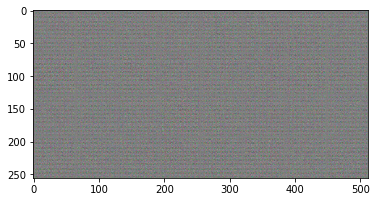

EPOCH 0 step 50: D: loss = 1.3725383 G: loss=0.7131379 
EPOCH 1 step 100: D: loss = 1.3632345 G: loss=0.6987204 
EPOCH 2 step 150: D: loss = 1.3803360 G: loss=0.7016983 
EPOCH 3 step 200: D: loss = 1.3752326 G: loss=0.6922006 
EPOCH 4 step 250: D: loss = 1.3737383 G: loss=0.6974969 
EPOCH 5 step 300: D: loss = 1.3785951 G: loss=0.6954687 
EPOCH 6 step 350: D: loss = 1.3756360 G: loss=0.7052611 
EPOCH 7 step 400: D: loss = 1.3594327 G: loss=0.7040583 
EPOCH 8 step 450: D: loss = 1.3709452 G: loss=0.6884682 
EPOCH 9 step 500: D: loss = 1.3729222 G: loss=0.6926301 
EPOCH 10 step 550: D: loss = 1.3693719 G: loss=0.6851560 
EPOCH 11 step 600: D: loss = 1.3649532 G: loss=0.6969749 
EPOCH 12 step 650: D: loss = 1.3524083 G: loss=0.7011336 
EPOCH 13 step 700: D: loss = 1.3647547 G: loss=0.6981611 
EPOCH 14 step 750: D: loss = 1.3584673 G: loss=0.7018826 
EPOCH 15 step 800: D: loss = 1.3568058 G: loss=0.7027752 
EPOCH 16 step 850: D: loss = 1.3441133 G: loss=0.7045800 
EPOCH 17 step 900: D: los

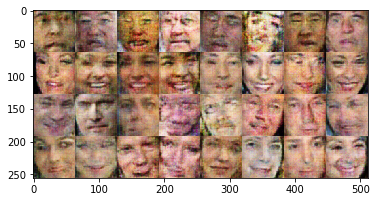

EPOCH 51 step 2650: D: loss = 1.1181455 G: loss=0.8161940 
EPOCH 52 step 2700: D: loss = 1.1164050 G: loss=0.8265642 
EPOCH 53 step 2750: D: loss = 1.1193476 G: loss=0.8519396 
EPOCH 54 step 2800: D: loss = 1.0807967 G: loss=0.8213793 
EPOCH 55 step 2850: D: loss = 1.1469762 G: loss=0.8313074 
EPOCH 56 step 2900: D: loss = 1.3291041 G: loss=0.7484409 
EPOCH 57 step 2950: D: loss = 1.0741934 G: loss=0.8526922 
EPOCH 58 step 3000: D: loss = 1.0776937 G: loss=0.7833480 
EPOCH 59 step 3050: D: loss = 1.0307368 G: loss=0.8909767 
EPOCH 60 step 3100: D: loss = 1.0107075 G: loss=0.9485297 
EPOCH 61 step 3150: D: loss = 0.9591969 G: loss=0.8695103 
EPOCH 62 step 3200: D: loss = 0.9471669 G: loss=0.9471734 
EPOCH 63 step 3250: D: loss = 5.1021490 G: loss=2.5264103 
EPOCH 64 step 3300: D: loss = 1.3923965 G: loss=0.7009252 
EPOCH 65 step 3350: D: loss = 1.3794929 G: loss=0.6879502 
EPOCH 66 step 3400: D: loss = 1.3572217 G: loss=0.6989847 
EPOCH 67 step 3450: D: loss = 1.3418857 G: loss=0.733604

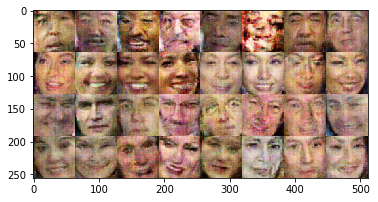

EPOCH 100 step 5150: D: loss = 0.6166245 G: loss=1.3474348 
EPOCH 101 step 5200: D: loss = 0.5736330 G: loss=1.4353936 
EPOCH 102 step 5250: D: loss = 0.6098162 G: loss=1.4594836 
EPOCH 103 step 5300: D: loss = 4.1077075 G: loss=2.3442824 
EPOCH 104 step 5350: D: loss = 1.3250206 G: loss=0.8392841 
EPOCH 105 step 5400: D: loss = 0.8760552 G: loss=1.0728872 
EPOCH 106 step 5450: D: loss = 0.7046224 G: loss=1.2909949 
EPOCH 107 step 5500: D: loss = 0.5577782 G: loss=1.3612996 
EPOCH 108 step 5550: D: loss = 0.5879294 G: loss=1.2206545 
EPOCH 109 step 5600: D: loss = 0.5468931 G: loss=1.3988245 
EPOCH 110 step 5650: D: loss = 0.5232123 G: loss=1.4708374 
EPOCH 111 step 5700: D: loss = 0.4865409 G: loss=1.4048164 
EPOCH 112 step 5750: D: loss = 0.5002074 G: loss=1.5048906 
EPOCH 113 step 5800: D: loss = 0.5075285 G: loss=1.4961830 
EPOCH 114 step 5850: D: loss = 0.5089101 G: loss=1.5553743 
EPOCH 115 step 5900: D: loss = 0.4835097 G: loss=1.5947577 
EPOCH 116 step 5950: D: loss = 0.4498223

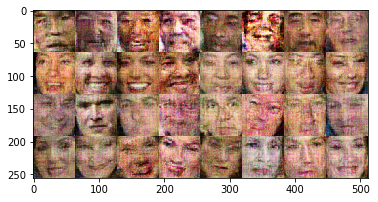

EPOCH 151 step 7750: D: loss = 0.2915823 G: loss=2.1648023 
EPOCH 152 step 7800: D: loss = 0.3266640 G: loss=2.0067677 
EPOCH 153 step 7850: D: loss = 0.3170097 G: loss=2.1666007 
EPOCH 154 step 7900: D: loss = 0.3314878 G: loss=2.1691298 
EPOCH 155 step 7950: D: loss = 0.3602113 G: loss=2.0492704 
EPOCH 156 step 8000: D: loss = 0.3119428 G: loss=2.1957812 
EPOCH 157 step 8050: D: loss = 0.2410942 G: loss=2.2264881 
EPOCH 158 step 8100: D: loss = 0.2856234 G: loss=1.9999580 
EPOCH 159 step 8150: D: loss = 0.2730906 G: loss=2.2093430 
EPOCH 160 step 8200: D: loss = 0.2322505 G: loss=2.2580693 
EPOCH 161 step 8250: D: loss = 0.2524973 G: loss=2.1235962 
EPOCH 162 step 8300: D: loss = 0.2471820 G: loss=2.2598040 
EPOCH 163 step 8350: D: loss = 0.3140585 G: loss=2.4151802 
EPOCH 164 step 8400: D: loss = 0.2625550 G: loss=2.2984200 
EPOCH 165 step 8450: D: loss = 0.2126025 G: loss=2.3796163 
EPOCH 166 step 8500: D: loss = 0.2176559 G: loss=2.3985655 
EPOCH 167 step 8550: D: loss = 0.2267729

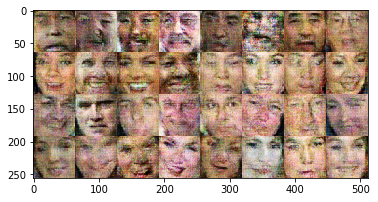

EPOCH 200 step 10250: D: loss = 1.3316457 G: loss=0.7661059 
EPOCH 201 step 10300: D: loss = 1.3593012 G: loss=1.2937742 
EPOCH 202 step 10350: D: loss = 0.6291348 G: loss=1.3818641 
EPOCH 203 step 10400: D: loss = 1.1068757 G: loss=1.1387405 
EPOCH 204 step 10450: D: loss = 0.5212274 G: loss=1.8014364 
EPOCH 205 step 10500: D: loss = 0.7760701 G: loss=1.6110203 
EPOCH 206 step 10550: D: loss = 0.4941665 G: loss=1.9296224 
EPOCH 207 step 10600: D: loss = 0.4006999 G: loss=2.0511987 
EPOCH 208 step 10650: D: loss = 0.3600662 G: loss=1.7363982 
EPOCH 209 step 10700: D: loss = 0.3057568 G: loss=2.0113251 
EPOCH 210 step 10750: D: loss = 0.2732866 G: loss=2.1055343 
EPOCH 211 step 10800: D: loss = 0.2888192 G: loss=2.1029432 
EPOCH 212 step 10850: D: loss = 0.2652741 G: loss=2.2669950 
EPOCH 213 step 10900: D: loss = 0.2403561 G: loss=2.2930713 
EPOCH 214 step 10950: D: loss = 0.2347799 G: loss=2.2907188 
EPOCH 215 step 11000: D: loss = 0.2291116 G: loss=2.4494309 
EPOCH 216 step 11050: D:

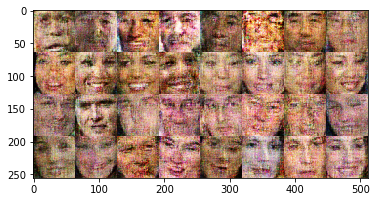

EPOCH 251 step 12850: D: loss = 0.2713946 G: loss=2.9539466 
EPOCH 252 step 12900: D: loss = 0.2536288 G: loss=3.0443506 
EPOCH 253 step 12950: D: loss = 0.1317908 G: loss=2.9500124 
EPOCH 254 step 13000: D: loss = 0.1394183 G: loss=2.9900560 
EPOCH 255 step 13050: D: loss = 0.1779347 G: loss=2.7728872 
EPOCH 256 step 13100: D: loss = 0.2623298 G: loss=2.8858688 
EPOCH 257 step 13150: D: loss = 0.1321596 G: loss=3.0145123 
EPOCH 258 step 13200: D: loss = 0.1760612 G: loss=2.7487307 
EPOCH 259 step 13250: D: loss = 0.1403980 G: loss=3.0457168 
EPOCH 260 step 13300: D: loss = 0.1151524 G: loss=3.1082249 
EPOCH 261 step 13350: D: loss = 0.1192555 G: loss=2.9380858 
EPOCH 262 step 13400: D: loss = 0.1183552 G: loss=3.1658878 
EPOCH 263 step 13450: D: loss = 0.1220236 G: loss=3.1433525 
EPOCH 264 step 13500: D: loss = 0.1321479 G: loss=3.1673455 
EPOCH 265 step 13550: D: loss = 27.2015171 G: loss=14.8959990 
EPOCH 266 step 13600: D: loss = 1.3789740 G: loss=0.7323050 
EPOCH 267 step 13650: 

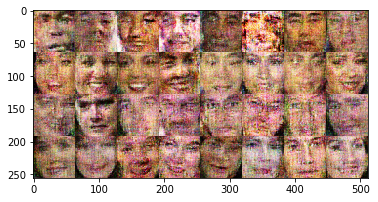

EPOCH 300 step 15350: D: loss = 0.1381497 G: loss=3.0131636 


In [7]:
#### TODO ####
import sys
from PIL import Image

sample_z = np.random.uniform(-1 , 1 , size = [batch_size, sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim, output_size)

##the loss of gerenate network
D_pro, D_logits = dis_net(images, y, False)
G_pro, G_logits = dis_net(fake_images, y, True)

#### TODO ####
# DEFINE LOSS FUNCTION #

D_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(G_pro), logits=G_logits))

D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_pro), logits=D_logits))
G_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(G_pro), logits=G_logits))

D_loss = D_real_loss + D_fake_loss
G_loss = G_fake_loss

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=g_learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=d_learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0
    loss_step = 50
    Row = 4
    Column = 8
    
    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im, label, batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:
                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if e % 50 == 0 and np.mod(step, display_step) == 1:
                sample_labels = sample_label_face(batch_size)
                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_labels})
                
                sample = []
                wb_label = [2, 1]
                for k in range(Row // 2):
                    cnt_1 = 0
                    tmp_1 = []
                    cnt_2 = 0
                    tmp_2 = []
                    for i, img in enumerate(sample_images):
                        if sample_labels[i][wb_label[k]] > 0:
                            if cnt_1 < 8 and sample_labels[i][0] > 0:
                                tmp_1.append(img)
                                cnt_1 += 1
                            elif cnt_2 < 8 and sample_labels[i][0] <= 0:
                                tmp_2.append(img)
                                cnt_2 += 1
                            if cnt_1 == 8 and cnt_2 == 8:
                                break
                    tmp_1 = np.hstack((np.asarray(tmp_1))) * 255
                    tmp_2 = np.hstack((np.asarray(tmp_2))) * 255
                    sample.append(np.asarray(np.append(tmp_1, tmp_2, axis=0)))
                sample = np.vstack((np.asarray(sample)))
                sample_images = Image.fromarray(sample.astype('uint8'))
                
                image_name = './{}/face_train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                sample_images.save(image_name)
                
                plt.imshow(sample_images)
                plt.show()
                
        e = e + 1
        batch_num = 0